[*********************100%%**********************]  3 of 3 completed
Half-life of mean reversion: 0.6535330657590273 days


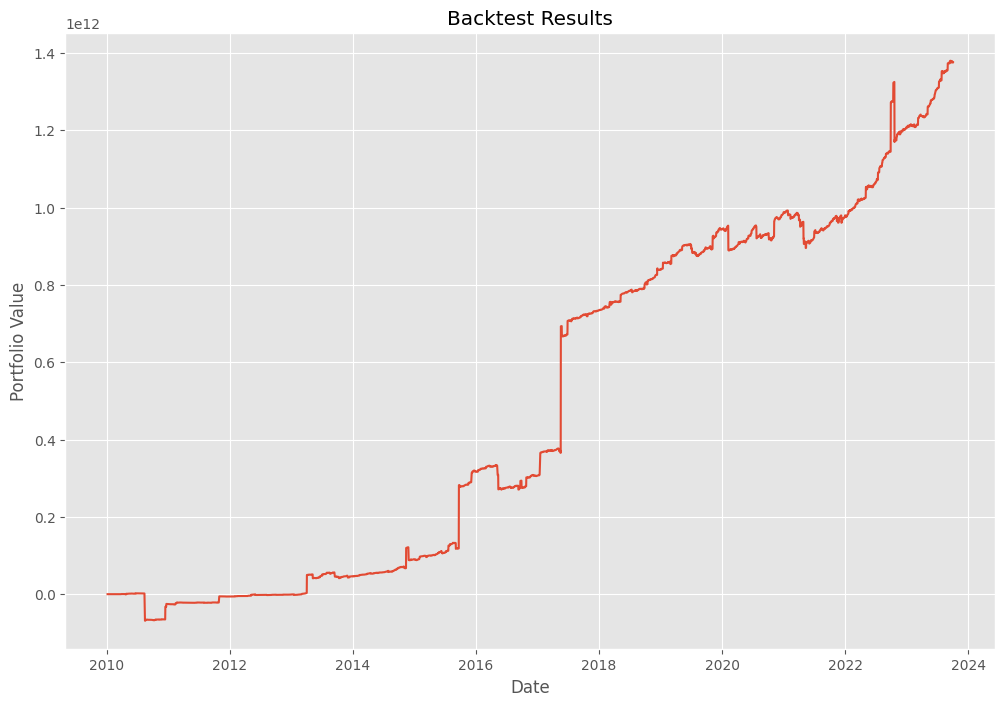

sharpe rato = 0.79


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yfinance as yf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
os.chdir("/users/pavelfedorov/documents")
import statsmodels.api as sm
# Download data
tickers = ['EWA', 'EWC', 'IGE']
data = yf.download(tickers, start="2010-01-01")['Adj Close']

# Calculate returns
returns = data.pct_change().dropna()

# Standardize returns
scaler = StandardScaler()
standardized_returns = scaler.fit_transform(returns)

# Apply PCA
pca = PCA()
pca.fit(standardized_returns)

# Get the eigenvector corresponding to the largest eigenvalue
principal_eigenvector = pca.components_[0]

# Construct the time series of the principal component portfolio
principal_component_portfolio = np.dot(standardized_returns, principal_eigenvector)

# You can convert this to a DataFrame for better readability
principal_component_df = pd.DataFrame(principal_component_portfolio, index=returns.index, columns=["Principal Component Portfolio"])


# Compute the lagged series
lagged = principal_component_df.shift(1).dropna()

# Compute the change (delta) of the series
delta = principal_component_df.diff().dropna()

# Prepare the lagged data for regression (remove NaN values from the start)
lagged = lagged.loc[delta.index]

# Perform the linear regression
X = lagged
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(delta, X)
results = model.fit()

# Extract the beta coefficient
beta = results.params["Principal Component Portfolio"]

# Calculate the half-life
half_life = -np.log(2) / beta

print(f"Half-life of mean reversion: {half_life} days")

# Calculate the moving average and standard deviation
window = 20  # for Bollinger Bands, usually a 20-day window is used, but this can be tuned
sma = principal_component_df.rolling(window=window).mean()
rolling_std = principal_component_df.rolling(window=window).std()

# Set the Bollinger Bands
k = 1  # This can be tuned
upper_band = sma + k * rolling_std
lower_band = sma - k * rolling_std

# Create buy and sell signals
principal_component_df['long_entry'] = principal_component_df['Principal Component Portfolio'] < lower_band['Principal Component Portfolio']
principal_component_df['long_exit'] = principal_component_df['Principal Component Portfolio'] > sma['Principal Component Portfolio']
principal_component_df['short_entry'] = principal_component_df['Principal Component Portfolio'] > upper_band['Principal Component Portfolio']
principal_component_df['short_exit'] = principal_component_df['Principal Component Portfolio'] < sma['Principal Component Portfolio']

# Backtest
initial_capital = 100000  # starting capital, for instance
positions = pd.DataFrame(index=principal_component_df.index).fillna(0.0)
positions['Principal Component Portfolio'] = 100 * principal_component_df['long_entry']  # Buy 100 units
positions['Principal Component Portfolio'] -= 100 * principal_component_df['short_entry']  # Short 100 units

# Compute portfolio holdings
principal_component_df['positions'] = positions.cumsum()

# Compute portfolio returns
principal_component_df['returns'] = principal_component_df['Principal Component Portfolio'].pct_change() * principal_component_df['positions'].shift()

# Compute portfolio value over time
principal_component_df['capital'] = initial_capital + (principal_component_df['returns'].cumsum() * initial_capital)

# Plotting the results for visualization
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
plt.plot(principal_component_df['capital'])
plt.title("Backtest Results")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.show()

sharpe=np.sqrt(252)*principal_component_df['returns'].mean()/principal_component_df['returns'].std()
print(f"sharpe rato = {round(sharpe,2)}")
